### Monte Carlo Release-Recapture Temperatures

In [12]:
using BeamPropagation, 
    Distributions, 
    UnitsToValue,
    StatsBase, 
    StaticArrays, 
    Plots,
    StructArrays,
    MutableNamedTuples,
    PhysicalConstants.CODATA2018,
    LinearAlgebra

In [13]:
# Define physical constants
const kB = BoltzmannConstant.val
const T = @with_unit 30 "μK"

# Define molecule parameters for CaOH
const m = @with_unit 57 "u"
const v_recoil = @with_unit 1.1 "cm/s"
;

In [14]:
# Define tweezer beam properties
const T_depth = @with_unit 1.4 "mK"
const U_max = kB * T_depth
const λ = 780e-9
const w0x = 2.0e-6
const w0y = 2.0e-6

# Create an instance of a gaussian trap for the tweezer
trap = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m)
;

In [15]:
total_time = @with_unit 5000 "μs"               
release_start_time = @with_unit 2000 "μs"        
release_end_time = @with_unit 2020 "μs"         
;

In [201]:
n = 5000
save_every = 100
delete_every = 50
dt_min = 1e-10
dt_max = 1e-4
abstol = 1e-5
dt = 1e-7
max_steps = Int64(ceil(total_time / dt))
alg = "rkf12"
use_adaptive = false
dt0 = 1e-5
times = (0:dt:max_steps * dt)[1:save_every:end-1]
;

In [202]:
discard(r, v) = false
is_detectable(r, trap) = (abs(r[1]) < 5trap.w0x) && (abs(r[2]) < 5trap.w0y) && (abs(r[3]) < 5max(trap.zRx, trap.zRy))

function update(particles, p, s, dt, time, idx)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        r = particles.r[i]
        s.detectable[idx] = is_detectable(r, p.trap)
    end
    return nothing
end

gravity(r) = SVector(0.0, -9.81, 0.0)

function f(idx, r, v, p, time)
    if p.release_start_time < time < p.release_end_time
        U_depth = 0.0
    else
        U_depth = p.trap.U_max
    end
    return F(r, p.trap) * U_depth / m + gravity(r)
end

function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        push!(s.trajectories[idx], particles.r[i])
    end
    return nothing
end
;

In [203]:
detectable = zeros(Bool, n)

particles = StructArray{Particle}(undef, n)
trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]

r, v, a = make_distributions(T, trap)

p = @params (trap, release_start_time, release_end_time)
s = @params (detectable, trajectories)

@time propagate_particles!(r, v, a, 
    alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true
)
mean(s.detectable) |> display

  1.527647 seconds (136.72 k allocations: 116.461 MiB, 231.98% compilation time: 5% of which was recompilation)


0.189

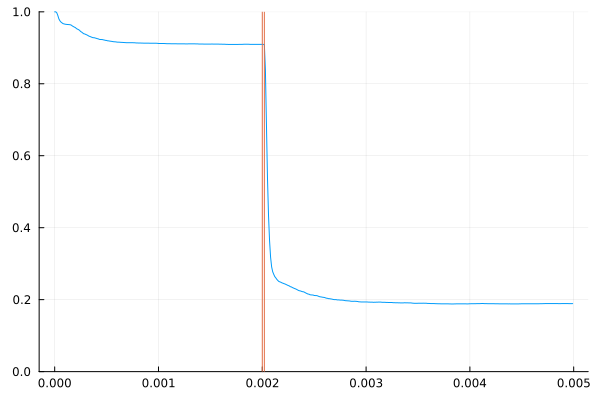

In [204]:
survival = vec(mean(mapreduce(permutedims, vcat, [[is_detectable(s.trajectories[i][j], trap) for j ∈ 1:length(times)] for i ∈ 1:n]), dims=1))
plot(times, survival, legend=nothing)
plot!(ylim=(0,1))
vline!([release_start_time, release_end_time])

## Scan in-trap temperature to fit to data

In [317]:
# 9/5/23, Lambda cooling
# data_xs = 1e-6 .* [
#      2
#      4
#      6
#      8
#     10
#     14
#     20
#     24
#     30
#     40
# ]
# data_ys = [
#     0.5600
#     0.4081
#     0.4766
#     0.4126
#     0.3687
#     0.1838
#     0.1913
#     0.1529
#     0.1297
#     0.0979
# ]

# 9/5/23, SF cooling
# data_xs = 1e-6 .* [
#     2
#     4
#     6
#     8
#     10
#     14
#     20
#     26
#     32
#     40
#     50
# ]
# data_ys = [
#     0.5690
#     0.5000
#     0.4909
#     0.5079
#     0.3871
#     0.1587
#     0.2364
#     0.1296
#     0.1379
#     0.0303
#     0.0294
# ]

# 9/5/23, no (100) in slowing
# data_xs = 1e-6 .* [
#     2
#     4
#     6
#     8
#     10
#     14
#     20
#     26
#     32
#     40
#     50
# ]
# data_ys = [
#     0.5690
#     0.5000
#     0.4909
#     0.5079
#     0.3871
#     0.1587
#     0.2364
#     0.1296
#     0.1379
#     0.0303
#     0.0294
# ]

# 9/5/23, no PID of tweezer intensity
# data_xs = 1e-6 .* [
#     2
#     4
#     6
#     8
#     10
#     14
#     20
#     26
#     32
#     40
#     50
# ]
# data_ys = [
#     0.4643
#     0.5422
#     0.5169
#     0.5190
#     0.4783
#     0.3711
#     0.2527
#     0.1806
#     0.1948
#     0.1299
#     0.0513
# ]

# data_xs = 1e-6 .* [
#     2
#     4
#     6
#     8
#     10
#     12
#     14
#     20
#     25
#     30
#     35
#     40
#     50
# ]

# data_ys = [
#     0.5654
#     0.5628
#     0.5039
#     0.4346
#     0.4327
#     0.4062
#     0.3110
#     0.2363
#     0.2262
#     0.1046
#     0.1092
#     0.0921
#     0.0678
# ]

# 9/14/23 - Lambda at 9 V detuning
data_xs = 1e-6 .* [
    2
    4
    6
    8
    10
    12
    14
    20
    24
    30
    34
    40
    50
]

data_ys = [
    0.6838
    0.6604
    0.5602
    0.4545
    0.4013
    0.3523
    0.2880
    0.2288
    0.2375
    0.1447
    0.1356
    0.0701
    0.0608
]

# Lambda at 8.3 V detuning
# data_xs = 1e-6 .* [
#     2
#     4
#     6
#     8
#     10
#     12
#     14
#     20
#     24
#     30
#     34
#     40
#     50
# ]

# data_ys = [
#     0.5867
#     0.6065
#     0.5810
#     0.4878
#     0.3742
#     0.3416
#     0.3012
#     0.2438
#     0.1712
#     0.1454
#     0.0747
#     0.1455
#     0.0833
# ];

# Lambda at 8.3 V detuning, mixer removed from tweezer electronics
# data_xs = 1e-6 .* [
#     2
#     4
#     6
#     8
#     10
#     12
#     14
#     20
#     24
#     30
#     34
#     40
#     50
# ]

# data_ys = [
#     0.6242
#     0.5929
#     0.6279
#     0.5419
#     0.3942
#     0.3810
#     0.3798
#     0.2781
#     0.1507
#     0.1161
#     0.1418
#     0.1319
#     0.0909
# ];

# 7.5 V detuning
# data_xs = 1e-6 .* [
#     2
#     4
#     6
#     8
#     10
#     12
#     14
#     20
#     24
#     30
#     34
#     40
#     50
# ]

# data_ys = [
#     0.5550
#     0.4474
#     0.4577
#     0.3910
#     0.3000
#     0.2344
#     0.2074
#     0.1069
#     0.1727
#     0.0938
#     0.0606
#     0.0547
#     0.0244
# ]

;

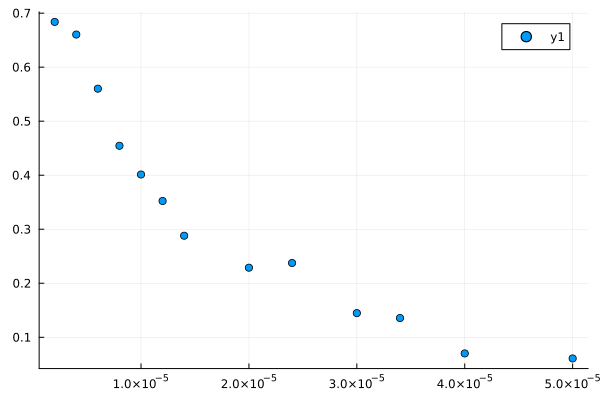

In [318]:
scatter(data_xs, data_ys)

In [319]:
const T = @with_unit 300 "μK";

In [320]:
const T = T_depth / 13;

In [321]:
# Create a release-recapture plot for a single temperature
r, v, a = make_distributions(T, trap)
release_durations = deepcopy(data_xs)

surviving_fractions = zeros(length(release_durations))
for (i, release_duration) ∈ enumerate(release_durations)

    # Reset parameters for current run
    p.release_start_time = release_start_time
    p.release_end_time = release_start_time + release_duration
    
    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    surviving_fractions[i] = mean(s.detectable)
end

  1.308138 seconds (20.76 k allocations: 108.726 MiB)
  1.318696 seconds (20.88 k allocations: 108.736 MiB)
  1.320950 seconds (20.88 k allocations: 108.736 MiB)
  1.321421 seconds (20.87 k allocations: 108.736 MiB)
  1.343390 seconds (20.88 k allocations: 108.736 MiB)
  1.354685 seconds (20.87 k allocations: 108.736 MiB)
  1.354675 seconds (20.87 k allocations: 108.736 MiB)
  1.362958 seconds (20.88 k allocations: 108.737 MiB)
  1.360553 seconds (20.87 k allocations: 108.736 MiB)
  1.355036 seconds (20.87 k allocations: 108.736 MiB)
  6.108192 seconds (20.89 k allocations: 108.736 MiB, 67.50% gc time)
  1.434513 seconds (20.87 k allocations: 108.736 MiB)
  1.411079 seconds (20.87 k allocations: 108.736 MiB)


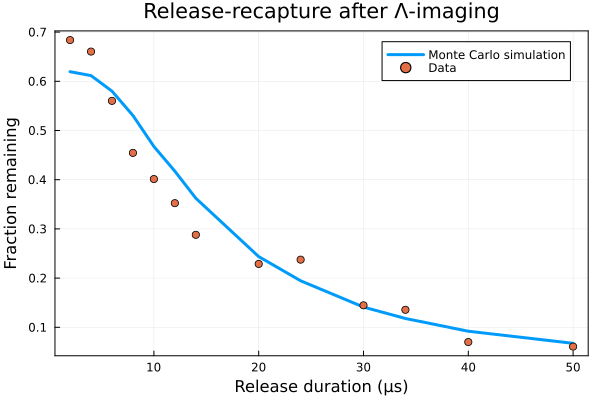

In [322]:
plot(release_durations .* 1e6, 0.62 * surviving_fractions,
    title="Release-recapture after Λ-imaging",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [323]:
ηs = 1:12
Ts = T_depth ./ ηs

release_durations = data_xs
surviving_fractions = Vector{Float64}[]

iter = Ts
for (i, T) ∈ enumerate(Ts)
    display(ηs[i])
    r, v, a = make_distributions(T, trap)
    surviving_fraction = zeros(length(release_durations))

    for (j, release_duration) ∈ enumerate(release_durations)

        # Reset parameters for current run
        p.release_start_time = release_start_time
        p.release_end_time = release_start_time + release_duration

        particles = StructArray{Particle}(undef, n)
        detectable = zeros(Bool, n)
        trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
        s = @params (detectable, trajectories)

        @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
            dt_min, dt_max, abstol, true)

        surviving_fraction[j] = mean(s.detectable)
        
    end
    push!(surviving_fractions, surviving_fraction) 
end

1

  1.387524 seconds (20.76 k allocations: 108.726 MiB)
  1.414234 seconds (20.88 k allocations: 108.736 MiB)
  1.422403 seconds (20.87 k allocations: 108.736 MiB)
  1.446232 seconds (20.87 k allocations: 108.736 MiB)
  1.413059 seconds (20.88 k allocations: 108.736 MiB)
  1.376343 seconds (20.87 k allocations: 108.736 MiB)
  1.390869 seconds (20.87 k allocations: 108.736 MiB)
  1.404011 seconds (20.87 k allocations: 108.736 MiB)
  1.388151 seconds (20.87 k allocations: 108.736 MiB)
  9.511619 seconds (20.89 k allocations: 108.736 MiB, 79.88% gc time)
  1.403279 seconds (20.87 k allocations: 108.736 MiB)
  1.390382 seconds (20.87 k allocations: 108.736 MiB)
  1.371194 seconds (20.87 k allocations: 108.736 MiB)


2

  1.335908 seconds (20.76 k allocations: 108.726 MiB)
  1.378814 seconds (20.87 k allocations: 108.736 MiB)
  1.380577 seconds (20.87 k allocations: 108.736 MiB)
  1.367012 seconds (20.87 k allocations: 108.736 MiB)
  1.359082 seconds (20.87 k allocations: 108.736 MiB)
  1.346958 seconds (20.87 k allocations: 108.736 MiB)
  1.352319 seconds (20.87 k allocations: 108.736 MiB)
  1.348536 seconds (20.87 k allocations: 108.736 MiB)
  1.405662 seconds (20.87 k allocations: 108.736 MiB)
  9.874383 seconds (20.89 k allocations: 108.736 MiB, 80.37% gc time)
  1.387310 seconds (20.87 k allocations: 108.736 MiB)
  1.391136 seconds (20.87 k allocations: 108.736 MiB)
  1.359673 seconds (20.87 k allocations: 108.736 MiB)


3

  1.324927 seconds (20.75 k allocations: 108.726 MiB)
  1.342700 seconds (20.87 k allocations: 108.736 MiB)
  1.348134 seconds (20.88 k allocations: 108.736 MiB)
  1.357595 seconds (20.87 k allocations: 108.736 MiB)
  1.361588 seconds (20.87 k allocations: 108.736 MiB)
  1.364719 seconds (20.87 k allocations: 108.736 MiB)
  1.354317 seconds (20.87 k allocations: 108.736 MiB)
  1.367760 seconds (20.87 k allocations: 108.736 MiB)
  1.394605 seconds (20.87 k allocations: 108.736 MiB)
  9.308846 seconds (20.88 k allocations: 108.736 MiB, 79.61% gc time)
  1.356301 seconds (20.87 k allocations: 108.736 MiB)
  1.369122 seconds (20.87 k allocations: 108.736 MiB)
  1.369537 seconds (20.87 k allocations: 108.736 MiB)


4

  1.361611 seconds (20.75 k allocations: 108.726 MiB)
  1.364079 seconds (20.88 k allocations: 108.736 MiB)
  1.327961 seconds (20.87 k allocations: 108.736 MiB)
  1.354910 seconds (20.88 k allocations: 108.736 MiB)
  1.358460 seconds (20.87 k allocations: 108.736 MiB)
  1.357465 seconds (20.88 k allocations: 108.736 MiB)
  1.388852 seconds (20.88 k allocations: 108.736 MiB)
  1.370867 seconds (20.88 k allocations: 108.736 MiB)
  1.388177 seconds (20.87 k allocations: 108.736 MiB)
  9.692755 seconds (20.88 k allocations: 108.736 MiB, 79.95% gc time)
  1.344808 seconds (20.88 k allocations: 108.736 MiB)
  1.347596 seconds (20.88 k allocations: 108.736 MiB)
  1.334955 seconds (20.87 k allocations: 108.736 MiB)


5

  1.320674 seconds (20.76 k allocations: 108.726 MiB)
  1.298810 seconds (20.88 k allocations: 108.736 MiB)
  1.328201 seconds (20.88 k allocations: 108.736 MiB)
  1.340923 seconds (20.88 k allocations: 108.736 MiB)
  1.336267 seconds (20.87 k allocations: 108.736 MiB)
  1.305570 seconds (20.88 k allocations: 108.736 MiB)
  1.345051 seconds (20.88 k allocations: 108.736 MiB)
  1.347625 seconds (20.87 k allocations: 108.736 MiB)
  1.342078 seconds (20.87 k allocations: 108.736 MiB)
  6.995485 seconds (20.89 k allocations: 108.736 MiB, 71.04% gc time)
  1.367033 seconds (20.88 k allocations: 108.736 MiB)
  1.378102 seconds (20.88 k allocations: 108.736 MiB)
  1.360648 seconds (20.88 k allocations: 108.736 MiB)


6

  1.317964 seconds (20.76 k allocations: 108.726 MiB)
  1.353374 seconds (20.87 k allocations: 108.736 MiB)
  1.363248 seconds (20.87 k allocations: 108.736 MiB)
  1.352146 seconds (20.87 k allocations: 108.736 MiB)
  1.355520 seconds (20.87 k allocations: 108.736 MiB)
  1.358792 seconds (20.88 k allocations: 108.736 MiB)
  1.367835 seconds (20.87 k allocations: 108.736 MiB)
  1.376693 seconds (20.88 k allocations: 108.736 MiB)
  1.379557 seconds (20.87 k allocations: 108.736 MiB)
  7.558926 seconds (20.87 k allocations: 108.736 MiB, 81.43% gc time)
  1.379312 seconds (20.88 k allocations: 108.736 MiB)
  1.367548 seconds (20.88 k allocations: 108.736 MiB)
  1.360448 seconds (20.88 k allocations: 108.737 MiB)


7

  1.305357 seconds (20.75 k allocations: 108.726 MiB)
  1.324135 seconds (20.87 k allocations: 108.736 MiB)
  1.342038 seconds (20.87 k allocations: 108.736 MiB)
  1.336012 seconds (20.87 k allocations: 108.736 MiB)
  1.347114 seconds (20.87 k allocations: 108.736 MiB)
  1.343185 seconds (20.87 k allocations: 108.736 MiB)
  1.352206 seconds (20.87 k allocations: 108.736 MiB)
  1.359100 seconds (20.87 k allocations: 108.736 MiB)
  1.363945 seconds (20.88 k allocations: 108.736 MiB)
  9.220175 seconds (20.89 k allocations: 108.736 MiB, 78.97% gc time)
  1.369776 seconds (20.87 k allocations: 108.736 MiB)
  1.376137 seconds (20.87 k allocations: 108.736 MiB)
  1.362848 seconds (20.87 k allocations: 108.736 MiB)


8

  1.337016 seconds (20.76 k allocations: 108.726 MiB)
  1.320567 seconds (20.87 k allocations: 108.736 MiB)
  1.322250 seconds (20.87 k allocations: 108.736 MiB)
  1.345868 seconds (20.88 k allocations: 108.736 MiB)
  1.330886 seconds (20.87 k allocations: 108.736 MiB)
  1.346223 seconds (20.87 k allocations: 108.736 MiB)
  1.352998 seconds (20.87 k allocations: 108.736 MiB)
  1.365393 seconds (20.87 k allocations: 108.736 MiB)
  1.370696 seconds (20.87 k allocations: 108.736 MiB)
  7.759520 seconds (20.89 k allocations: 108.736 MiB, 74.91% gc time)
  1.362155 seconds (20.87 k allocations: 108.736 MiB)
  1.352388 seconds (20.87 k allocations: 108.736 MiB)
  1.366138 seconds (20.87 k allocations: 108.736 MiB)


9

  1.318095 seconds (20.75 k allocations: 108.726 MiB)
  1.327584 seconds (20.87 k allocations: 108.736 MiB)
  1.312880 seconds (20.87 k allocations: 108.736 MiB)
  1.333950 seconds (20.87 k allocations: 108.736 MiB)
  1.341488 seconds (20.88 k allocations: 108.736 MiB)
  1.339092 seconds (20.88 k allocations: 108.736 MiB)
  1.345837 seconds (20.88 k allocations: 108.736 MiB)
  1.339109 seconds (20.88 k allocations: 108.736 MiB)
  1.333905 seconds (20.88 k allocations: 108.736 MiB)
  7.324701 seconds (20.89 k allocations: 108.736 MiB, 73.71% gc time)
  1.365215 seconds (20.88 k allocations: 108.736 MiB)
  1.355393 seconds (20.88 k allocations: 108.736 MiB)
  1.362030 seconds (20.88 k allocations: 108.736 MiB)


10

  1.303603 seconds (20.76 k allocations: 108.726 MiB)
  1.302353 seconds (20.88 k allocations: 108.737 MiB)
  1.363967 seconds (20.87 k allocations: 108.736 MiB)
  1.337392 seconds (20.87 k allocations: 108.736 MiB)
  1.337576 seconds (20.87 k allocations: 108.736 MiB)
  1.334839 seconds (20.87 k allocations: 108.736 MiB)
  1.365632 seconds (20.87 k allocations: 108.736 MiB)
  1.355676 seconds (20.87 k allocations: 108.736 MiB)
  1.352069 seconds (20.87 k allocations: 108.736 MiB)
  7.898284 seconds (20.89 k allocations: 108.737 MiB, 75.18% gc time)
  1.395245 seconds (20.88 k allocations: 108.736 MiB)
  1.373053 seconds (20.87 k allocations: 108.736 MiB)
  1.388810 seconds (20.88 k allocations: 108.736 MiB)


11

  1.326018 seconds (20.75 k allocations: 108.726 MiB)
  1.319785 seconds (20.87 k allocations: 108.736 MiB)
  1.334335 seconds (20.88 k allocations: 108.736 MiB)
  1.341763 seconds (20.87 k allocations: 108.736 MiB)
  1.347986 seconds (20.87 k allocations: 108.736 MiB)
  1.357729 seconds (20.88 k allocations: 108.737 MiB)
  1.352771 seconds (20.88 k allocations: 108.736 MiB)
  1.360460 seconds (20.87 k allocations: 108.736 MiB)
  1.347570 seconds (20.88 k allocations: 108.736 MiB)
  9.051042 seconds (20.88 k allocations: 108.736 MiB, 78.74% gc time)
  1.354702 seconds (20.88 k allocations: 108.737 MiB)
  1.342277 seconds (20.88 k allocations: 108.736 MiB)
  1.336640 seconds (20.88 k allocations: 108.736 MiB)


12

  1.284455 seconds (20.76 k allocations: 108.726 MiB)
  1.312547 seconds (20.88 k allocations: 108.736 MiB)
  1.305984 seconds (20.87 k allocations: 108.736 MiB)
  1.347914 seconds (20.87 k allocations: 108.736 MiB)
  1.338828 seconds (20.87 k allocations: 108.736 MiB)
  1.337353 seconds (20.87 k allocations: 108.736 MiB)
  1.357103 seconds (20.87 k allocations: 108.736 MiB)
  1.349971 seconds (20.87 k allocations: 108.736 MiB)
  1.352005 seconds (20.88 k allocations: 108.736 MiB)
  9.260767 seconds (20.76 k allocations: 108.726 MiB, 79.07% gc time)
  1.380036 seconds (20.87 k allocations: 108.736 MiB)
  1.385567 seconds (20.87 k allocations: 108.736 MiB)
  1.381535 seconds (20.88 k allocations: 108.736 MiB)


In [332]:
χ²(data, preds) = sum((data .- preds).^2 ./ 0.04^2);

In [333]:
function model_with_best_scaling(data_ys, model_ys)
    min_error = Inf
    best_scaling = 1.0 
    for scaling ∈ 0.1:0.01:5.0
        error = χ²(data_ys, model_ys .* scaling)
        if error < min_error
            min_error = error
            best_scaling = scaling
        end
    end
    println(best_scaling)
    return model_ys .* best_scaling
end

model_with_best_scaling (generic function with 1 method)

In [334]:
χ²_errors = [
    χ²(
        data_ys,
        model_with_best_scaling(data_ys, surviving_fractions[i])
        )
    for i ∈ 1:size(surviving_fractions, 1)]
;

5.0
1.83
1.17
0.93
0.83
0.77
0.72
0.69
0.67
0.65
0.63
0.61


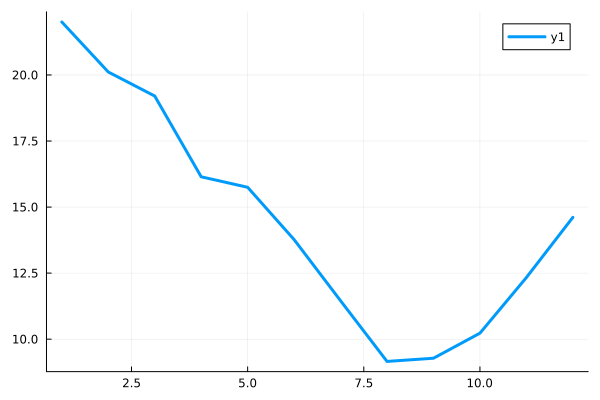

In [335]:
plot(T_depth ./ Ts, χ²_errors,
    linewidth=3,
    )

In [336]:
# χ²_errors_1 = deepcopy(χ²_errors)
# χ²_errors_2 = deepcopy(χ²_errors)
# χ²_errors_3 = deepcopy(χ²_errors)
# χ²_errors_4 = deepcopy(χ²_errors)

In [337]:
plot(T_depth ./ Ts, χ²_errors_1,
    linewidth=3,
    xlabel="η",
    ylabel="χ² error",
    label="SF cooling",
    box=:on,
    title="χ² errors vs. η for release-recapture data" 
    )
plot!(T_depth ./ Ts, χ²_errors_2,
    linewidth=3,
    label="SF cooling, (100) slowing repumper off"
    )
plot!(T_depth ./ Ts, χ²_errors_3,
    linewidth=3,
    label="SF cooling, tweezer intensity PID off"
    )
plot!(T_depth ./ Ts, χ²_errors_4,
    linewidth=3,
    label="Lambda cooling"
    )

LoadError: UndefVarError: `χ²_errors_1` not defined

0.000175

0.69


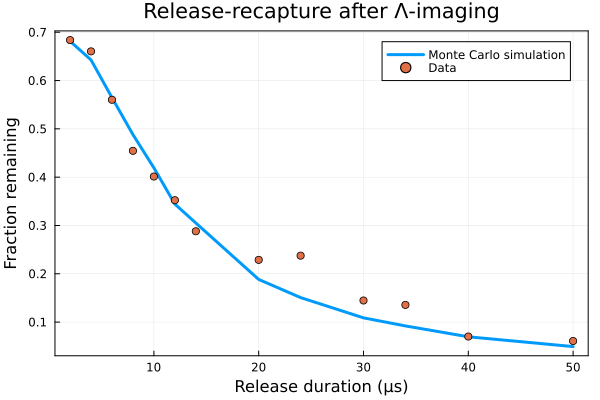

In [330]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds,
    title="Release-recapture after Λ-imaging",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

0.000175

0.69


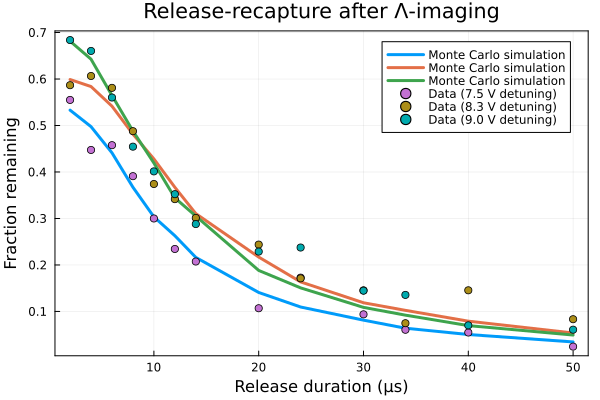

In [339]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds_75,
    title="Release-recapture after Λ-imaging",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
plot!(release_durations .* 1e6, best_preds_83, linewidth=3, label="Monte Carlo simulation")
plot!(release_durations .* 1e6, best_preds_90, linewidth=3, label="Monte Carlo simulation")
scatter!(data_xs_75 .* 1e6, data_ys_75, label="Data (7.5 V detuning)")
scatter!(data_xs_83 .* 1e6, data_ys_83, label="Data (8.3 V detuning)")
scatter!(data_xs_90 .* 1e6, data_ys_90, label="Data (9.0 V detuning)")

In [338]:
data_xs_90 = deepcopy(data_xs)
data_ys_90 = deepcopy(data_ys)
best_preds_90 = deepcopy(best_preds)
;

In [310]:
# data_xs_75 = deepcopy(data_xs)
# data_ys_75 = deepcopy(data_ys)
# best_preds_75 = deepcopy(best_preds)
# ;

In [297]:
# data_xs_83 = deepcopy(data_xs)
# data_ys_83 = deepcopy(data_ys)
# best_preds_83 = deepcopy(best_preds)
# ;

0.0001076923076923077

0.62


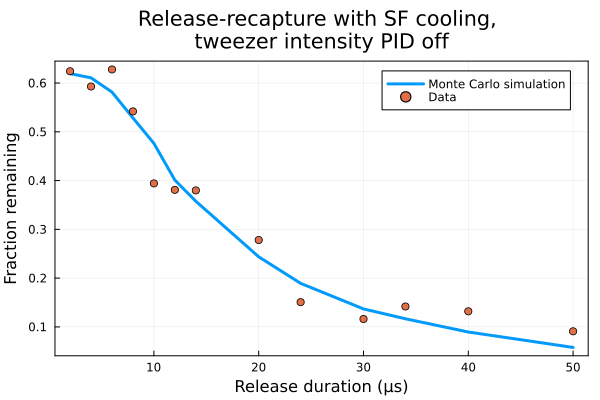

In [218]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds,
    title="Release-recapture with SF cooling, \n tweezer intensity PID off \n",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [219]:
using LsqFit
@. model(T, p) = p[1] * (T - p[2])^2 + p[3]

model (generic function with 1 method)

3-element Vector{Float64}:
  0.40431920757207523
 13.375433962787678
 10.62239901413702

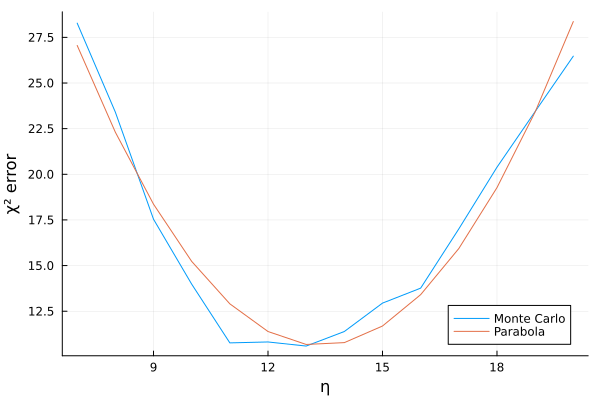

In [231]:
x = 0
y = 0

lb = [0, 0.0, 0.]
p0 = [0., 8, 0.]
ub = [1.0, 20, 20.0]
fitted_model = curve_fit(model, ηs[x+1:end-y], χ²_errors[x+1:end-y], p0, lower=lb, upper=ub)
display(fitted_model.param)
plot(ηs[x+1:end-y], χ²_errors[x+1:end-y], label="Monte Carlo", xlabel="η", ylabel="χ² error")
plot!(ηs[x+1:end-y], model(ηs[x+1:end-y], fitted_model.param), label="Parabola")

In [228]:
# The second derivative with respect to T is given by
sqrt(2 * (2fitted_model.param[3])^(-1))

0.30736094390899366

### Bootstrap model outputs to get an error range

In [ ]:
surviving_fractions

In [24]:
n = 2_000
T = 60e-6
r, v, a = make_distributions(T)

simul_xs = collect(shaved_U_depth_ratios[1]:0.01:shaved_U_depth_ratios[end])

detectable_all = zeros(n, length(simul_xs))

for (j, shaved_U_depth_ratio) ∈ enumerate(simul_xs)
    shaved_U_depth = original_U_depth * shaved_U_depth_ratio

    # Reset parameters for current run
    p.time = 0.0
    p.shaved_U_depth = shaved_U_depth

    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    detectable_all[:,j] .= s.detectable
    
end

LoadError: MethodError: no method matching make_distributions(::Float64)

[0mClosest candidates are:
[0m  make_distributions(::Any, [91m::AsymmetricGaussianTrap[39m)
[0m[90m   @[39m [36mBeamPropagation[39m [90mC:\Google Drive\github\BeamPropagation\src\[39m[90m[4mAsymmetricGaussianTrap.jl:54[24m[39m


In [25]:
n_bootstraps = 10000

surviving_fractions_lower = zeros(length(simul_xs))
surviving_fractions_upper = zeros(length(simul_xs))

for i ∈ eachindex(simul_xs)
    bootstrap_idxs = rand(1:n, n, n_bootstraps)
    bootstrap_samples = detectable_all[:,i][bootstrap_idxs]
    bootstrap_means = vec(mean(bootstrap_samples, dims=1))
    surviving_fractions_lower[i] = percentile(bootstrap_means, 50 - 34.1)
    surviving_fractions_upper[i] = percentile(bootstrap_means, 50 + 34.1)
end

LoadError: UndefVarError: `simul_xs` not defined

In [26]:
plot(simul_xs, surviving_fractions_lower, fillrange=surviving_fractions_upper, legend=nothing)

LoadError: UndefVarError: `surviving_fractions_upper` not defined

In [27]:
simul_vals = vec(mean(detectable_all, dims=1));

LoadError: UndefVarError: `detectable_all` not defined

In [28]:
simul_vals

LoadError: UndefVarError: `simul_vals` not defined

### Bootstrapping data

In [29]:
using Distributions

In [30]:
data_sampler(μs, ϵs) = [Normal(μs[i], ϵs[i]) for i ∈ eachindex(μs)]
ds = data_sampler(data_ys, data_ys_errors)
;

LoadError: UndefVarError: `data_ys_errors` not defined

In [31]:
n_bootstraps = 100_000
min_Ts = zeros(n_bootstraps)

for i ∈ 1:n_bootstraps
    bootstrap_sample = rand.(ds)
    squared_errors = vec(sum((bootstrap_sample .- surviving_fractions').^2 ./ length(data_ys), dims=1))
    _, best_idx = findmin(squared_errors)
    min_Ts[i] = Ts[best_idx]
end
histogram(min_Ts, bins=Ts)

LoadError: UndefVarError: `ds` not defined

In [32]:
mean(min_Ts)

0.0

In [33]:
percentile(min_Ts, 50 - 34.1) |> display
percentile(min_Ts, 50 + 34.1) |> display

0.0

0.0